In [258]:
from math import floor, exp, sqrt, pi
import cmath
import numpy
from numpy import e, cos, zeros, arange, roll, where, random, ones, mean, reshape, dot, array, flipud, pi, exp, dot, angle, degrees, shape, linspace
import matplotlib.pyplot as plt
from itertools import chain
import scipy
from scipy import special
import numpy as np 
import seaborn as sns
import time
from joblib import Parallel, delayed
import multiprocessing
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import scipy.signal
from scipy.optimize import curve_fit 


numcores = multiprocessing.cpu_count()-3
numcores


def decode_rE(rE, a_ini=0, a_fin=360, N=512):
    #Population vector for a given rE
    # return ( angle in radians, absolut angle in radians, abs angle in degrees )
    N=len(rE)
    Angles = np.linspace(a_ini, a_fin, N) 
    angles=np.radians(Angles)
    rE = np.reshape(rE, (1,N))
    R = numpy.sum(np.dot(rE,exp(1j*angles)))/numpy.sum(rE)
    
    angle_decoded = np.degrees(np.angle(R))
    if angle_decoded<0:
        angle_decoded = 360+angle_decoded
    
    return angle_decoded
    #Mat.append(  [angle(R), abs(angle(R)) , degrees(abs(angle(R)))]  )
    #return round( np.degrees(abs(np.angle(R))), 2)





def circ_dist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)


def most_frequent(List): 
    dict = {} 
    count, itm = 0, '' 
    for item in reversed(List): 
        dict[item] = dict.get(item, 0) + 1
        if dict[item] >= count : 
            count, itm = dict[item], item 
    return(itm) 


def Interference_effects(target, response, reference):
    #input list of target, list of responses and list of references
    #Error_interference; positive for attraction and negative for repulsion
    #######
    #Decimals to get
    decimals=2
    ####
    interferences=[]
    for i in range(0, len(target)):
        angle_err_abs=abs(target[i] - response[i])
        if circ_dist(np.array(response)[i], np.array(reference)[i])<=circ_dist(np.array(target)[i], np.array(reference)[i]):
            Err_interference=round( angle_err_abs, decimals) 
        else:
            Err_interference=round( -angle_err_abs, decimals)
        interferences.append(Err_interference)
    
    return interferences


def viz_polymonial(X, y, poly_reg, pol_reg):
    plt.figure()
    plt.scatter(X, y, color='red')
    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
    plt.title('Fit Bump')
    plt.xlabel('Neuron')
    plt.ylabel('rate')
    plt.show(block=False)
    return




def simulation(totalTime, targ_onset, dist_onset, presentation_period, separation, 
               tauE=60, tauI=10, tauf=7000, taud=80, I0E=1.3, I0I=0.4, U=0.4,
               GEE=0.016, GEI=0.015, GIE=0.012 , GII=0.007, sigE=0.06, sigI=0.04,
               kappa_E=100, kappa_I=1.5, k_inhib=0.07, kappa_stim=20,
               N=512, plot_connectivity=True, plot_dyniamic=True, plot_heatmap=True, plot_fit=True ):
    
    ###### temporal and spatial settings
    st_sim =time.time()
    dt=2;
    nsteps=int(floor(totalTime/dt));
    origin = pi;
    targ_offset = targ_onset + presentation_period;
    targon = floor(targ_onset/dt);
    targoff = floor(targ_offset/dt);
    
    dist_offset = dist_onset  + presentation_period;
    diston = floor(dist_onset/dt);
    distoff = floor(dist_offset/dt);
    stim_sep = pi/separation; #(13 attract, 9 solo 1, 5 repulsion, 2 nada)
    
    targ_dist_delay = dist_onset - targ_offset
    
    ###### Connectivities
    v_E=np.zeros((N));
    v_I=np.zeros((N));
    WE=np.zeros((N,N));
    WI=np.zeros((N,N));
    theta = [float(range(0,N)[i])/N*2*pi for i in range(0,N)];
    for i in range(0, N):
        v_E_new=[e**(kappa_E*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_E)) for f in range(0, len(theta))]    
        v_I_new=[e**(kappa_I*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_I)) + k_inhib for f in range(0, len(theta))] #0.18
        ###    
        vE_NEW=np.roll(v_E_new,i)
        vI_NEW=np.roll(v_I_new,i) #to roll
        ###    
        WE[:,i]=vE_NEW
        WI[:,i]=vI_NEW
    ##
    # Plot of the connectivity profile
    if plot_connectivity ==True:
        plt.figure()
        plt.plot(WE[250, :], label='E')
        plt.plot(WI[250, :], label = 'I')
        plt.ylim(0,6)
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.title('Connectivity WE & WI')
        plt.show(block=False)
        plt.figure()
        plt.plot(WE[250, :] - WI[250, :] , label='E-I')
        #plt.plot(WI[250, :], label = 'I')
        #plt.ylim(0,6)
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.title('Effective onnectivity')
        plt.show(block=False)
    #topography_pattern  =  WE[250, :] + -1*(WI[250, :]) ##plot the topography of the connectivities
    #plt.plot(topography_pattern, 'k')
    #plt.show(block=False)
    
    ###### Stimuli
    target=np.zeros((N))
    distractor=np.zeros((N))
    for i in range(0, N):
        target[i]=e**(kappa_stim*cos(theta[i] + origin - stim_sep)) / (2*pi*scipy.special.i0(kappa_stim)) 
        distractor[i]=e**(kappa_stim*cos(theta[i] + origin + stim_sep)) / (2*pi*scipy.special.i0(kappa_stim)) 


    target = target+ np.random.normal(0, 0.01, N)
    target=reshape(target, (N,1))
    distractor = distractor+ np.random.normal(0, 0.01, N)
    distractor=reshape(distractor, (N,1)) 
    
    #plt.plot(target) ##plot the target and distractor
    #plt.plot(distractor)
    #plt.show(block=False)
    
    ###### Model   
    rE=np.zeros((N,1));
    rI=np.zeros((N,1)); 
    u = np.ones((N,1))*U
    x = np.ones((N,1))
    RE=np.zeros((N,nsteps));
    RI=np.zeros((N,nsteps));
    p_u=np.ones((N,nsteps));
    p_x=np.ones((N,nsteps));
    
    f = lambda x : x*x*(x>0)*(x<1) + reshape(array([cmath.sqrt(4*x[i]-3) for i in range(0, len(x))]).real, (N,1)) * (x>=1)
    
    ### diferential equations
    for i in range(0, nsteps):
        noiseE = sigE*random.randn(N,1);
        noiseI = sigI*random.randn(N,1);

        #differential equations for connectivity
        IE= GEE*dot(WE, (rE*u*x)) - GIE*dot(WI,rI) + I0E*ones((N,1)); 
        II= GEI*dot(WE,rE) +  (I0I-GII*mean(rI))*ones((N,1));

        if i>targon and i<targoff:
            IE=IE+target;
            II=II+target;

        if i>diston and i<distoff:
            IE=IE+distractor;
            II=II+distractor;


        #rates of exit and inhib   
        rE = rE + (f(IE) - rE + noiseE)*dt/tauE;
        rI = rI + (f(II) - rI + noiseI)*dt/tauI;
        ### formulas for synaptic plasticity: paper mongillo 2008
        u = u + ((U - u) / tauf + U*(1-u)*rE/1000)*dt;
        x = x + ((1 - x)/taud - u*x*rE/1000)*dt;
        
        rEr=np.reshape(rE, N)
        rIr=np.reshape(rI, N)
        ur=np.reshape(u, N)
        xr=np.reshape(x, N)
        #append
        RE[:,i] = rEr;
        RI[:,i] = rIr;
        p_u[:,i] = ur;
        p_x[:,i] = xr;
    
    
    #### Interference
    interference = Interference_effects( [decode_rE(target)], [decode_rE(rE)], [decode_rE(distractor)])[0] ## just one bump
    p_targ = int((N * np.degrees(origin + stim_sep))/360)
    
    if plot_dyniamic==True:
        #### plot dynamics
        fig = plt.figure()
        fig.tight_layout()
        fig.set_size_inches(13, 4)
        fig.add_subplot(131)
        p_targ = int((N * np.degrees(origin + stim_sep))/360)
        plt.title('Synaptic dynamics for target')
        plt.plot(p_u[p_targ, :], 'b', label='prob. release')
        plt.plot(p_x[p_targ, :], 'r', label='pool vesicles')
        plt.xlabel('time (ms)')
        plt.legend()
        fig.add_subplot(132)
        p_dist= int((N * np.degrees(origin - stim_sep))/360)
        plt.title('Synaptic dynamics for distractor')
        plt.plot(p_u[p_dist, :], 'b', label='prob.y release')
        plt.plot(p_x[p_dist, :], 'r', label='pool vesicles')
        plt.xlabel('time (ms)')
        plt.legend()
        fig.add_subplot(133)
        plt.title('Rate dynamics')
        plt.plot(RE[p_targ, :], 'b', label='target')
        plt.plot(RE[p_dist, :], 'r', label='distractor')
        plt.xlabel('time (ms)')
        plt.ylabel('rate (Hz)')
        plt.legend()
        plt.show(block=False)
    #
    if plot_heatmap==True:
        #### plot heatmap
        RE_sorted=flipud(RE)
        p_dist= int((N * np.degrees(origin - stim_sep))/360)
        plt.figure(figsize=(9,6))
        sns.heatmap(RE_sorted, cmap='viridis')
        plt.title('BUMP activity')
        plt.ylabel('Angle')
        plt.xlabel('time')
        plt.plot([targon, nsteps], [p_dist, p_dist], '--b',) ## flipped, so it is p_target 
        plt.plot([diston, nsteps], [p_targ, p_targ], '--r',) ## flipped, so it is p_target 
        plt.yticks([])
        plt.xticks([])
        plt.yticks([N/8, 3*N/8, 5*N/8, 7*N/8 ] ,['45','135','225', '315'])
        plt.plot([targ_onset/2, targ_onset/2,], [0+20, N-20], 'k-', label='onset')
        plt.plot([targ_offset/2, targ_offset/2,], [0+20, N-20], 'k--', label='offset')
        plt.plot([dist_onset/2, dist_onset/2,], [0+20, N-20], 'k-')
        plt.plot([dist_offset/2, dist_offset/2,], [0+20, N-20], 'k--')
        plt.legend()
        plt.show(block=False)
    
    
    ## print time consumed
    end_sim =time.time()
    total_time= end_sim - st_sim 
    total_time = round(total_time, 1)
    print('Simulation time: ' + str(total_time) + 's')
    
    
    #### Fit
        ###### Fit
    def von_misses(x,mu,k):
        return (exp( k * cos(x-mu))) / (2*pi*scipy.special.i0(k)) 

    def bi_von_misses(x,mu1,k1,mu2,k2):
        return von_misses(x,mu1,k1) + von_misses(x,mu2,k2)

    ##
    y=np.reshape(rE, (N)) 
    X=np.reshape(np.linspace(-pi, pi, N), N)

    ### Fit
    df_n_p=pd.DataFrame()
    df_n_p['rE'] = rE.reshape(512)
    peaks_list=[]
    for n_w_s in range(1, 100):
        r = df_n_p['rE'].rolling(window=n_w_s).mean()
        number_of_bumps = len(scipy.signal.find_peaks(r, 2)[0]) 
        peaks_list.append(number_of_bumps)
    #
    if number_of_bumps == 0:
        if peaks_list==[0 for i in range(len(peaks_list))]:
            number_of_bumps = 0
        else:
            peaks_list[:] = (value for value in peaks_list if value != 0)
            number_of_bumps=most_frequent(peaks_list)
    #
    number_of_bumps=most_frequent(peaks_list)
    #print(number_of_bumps)
    number_of_bumps = 2


    ### Fit
    if number_of_bumps ==2:
        param, covs = curve_fit(bi_von_misses, X, y, p0=[separation, 75, -separation, 75]) #, p0=[separation, 75, -separation, 75]
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) + (exp( param[3] * cos(X-param[2]))) / (2*pi*scipy.special.i0(param[3])) 
        estimated_angles=[]
        for p in [param[0], param[2]]:
            estim_ang = np.degrees(p)
            if estim_ang<0:
                estim_ang = 360+estim_ang
            estimated_angles.append(estim_ang)
        
        #          
        estimated_angle_1=estimated_angles[0]
        estimated_angle_2=estimated_angles[1]
        #print(estimated_angle_1, estimated_angle_2)
        estimated_angles = [estimated_angle_1, estimated_angle_2]
        #estimated_angles.sort()
        #
        
        
        ### wich one is the target and which the distractor?????
        
        
        min_bias = min(  abs(np.degrees( origin + pi/separation) - estimated_angle_1 ), abs( np.degrees( origin - pi/separation) - estimated_angle_1  ) )
        if min_bias == abs(np.degrees( origin + pi/separation) - estimated_angle_1 ):
            dist_ang = estimated_angle_1
            targ_ang = estimated_angle_2
            #bias_b1 = np.degrees( origin + pi/separation) -  estimated_angle_1 
            #bias_b2 = np.degrees( origin - pi/separation) -  estimated_angle_2 
            ####
            #bias_dist = Interference_effects(  [np.degrees( origin + pi/separation)],  [dist_ang],  [np.degrees( origin - pi/separation)])[0]
            #bias_target = Interference_effects(  [np.degrees( origin - pi/separation)],  [targ_ang],  [np.degrees( origin + pi/separation)])[0]
            #
            bias_dist = Interference_effects(  [decode_rE(target)],  [dist_ang],  [decode_rE(distractor)])[0]
            bias_target = Interference_effects(  [decode_rE(distractor)],  [targ_ang],  [decode_rE(target)])[0]
            

        else:
            targ_ang = estimated_angle_1
            dist_ang = estimated_angle_2
            #bias_b1 = np.degrees( origin - pi/separation) -  estimated_angle_1 
            #bias_b2 = np.degrees( origin + pi/separation) -  estimated_angle_2 
            ####
            #decode_rE(target)
            #bias_target = Interference_effects(  [np.degrees( origin - pi/separation)],  [targ_ang],  [np.degrees( origin + pi/separation)])[0]
            #bias_dist = Interference_effects(  [np.degrees( origin + pi/separation)],  [dist_ang],  [np.degrees( origin - pi/separation)])[0]
            ##
            bias_target = Interference_effects(  [decode_rE(distractor)],  [targ_ang],  [decode_rE(target)])[0]
            bias_dist = Interference_effects(  [decode_rE(target)],  [dist_ang],  [decode_rE(distractor)])[0]
            
            ##
        
        ###
        #print('target',round(targ_ang,2), round(decode_rE(distractor), 2), round(bias_target,2))
        #print('distractor', round(dist_ang,2), round(decode_rE(target),2), round(bias_dist,2))
        final_bias = [bias_target, bias_dist]
        skip_r_sq=False
        success=True
        #print(np.degrees( origin - pi/separation), decode_rE(target))
        #print(np.degrees( origin + pi/separation), decode_rE(distractor))
        #print(targ_ang, dist_ang)

    elif number_of_bumps ==1:
        param, covs = curve_fit(von_misses, X, y)
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) 
        estimated_angle=np.degrees(param[0]+pi)  
        
        min_bias = min(  abs(estimated_angle - np.degrees( origin + pi/separation)), 
                       abs(estimated_angle - np.degrees( origin - pi/separation))  )
        if min_bias == abs(estimated_angle - np.degrees( origin + pi/separation)):
            bias_b1 = estimated_angle - np.degrees( origin + pi/separation)
            bias_b2 = estimated_angle - np.degrees( origin - pi/separation)
        else:
            bias_b1 = estimated_angle - np.degrees( origin - pi/separation)
            bias_b2 = estimated_angle - np.degrees( origin + pi/separation)
        ##
        #bias_b1 = estimated_angle - np.degrees( origin - pi/separation)
        #bias_b2 = np.degrees(origin + pi/separation) - estimated_angle  ## bias (positive means attraction)
        final_bias = [bias_b1, bias_b2]  
        skip_r_sq=False
        success=True

    else:
        print('Error simultaion')
        final_bias=[999, 999]
        plot_fit=False
        skip_r_sq=True
        r_squared=0
        success=False ## to eliminate wrong simulations easily at the end

    #error_fit (r_squared)
    if skip_r_sq==False:
        residuals = y - ans
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-numpy.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)

    #plot fit
    if plot_fit==True:
        plt.figure()
        plt.plot(X, y, 'o', color ='red', label ="data") 
        plt.plot(X, ans, '--', color ='blue', label ="fit") 
        plt.legend() 
        plt.show(block=False) 
    
    ### Output
    #return RE,  RI, p_u, p_x
    #return interference, targ_dist_delay 
    max_re = max(rE)[0]
    ### interfernce max
    dec_far = np.linspace(180,0,int(N/2))[np.where(y[int(N/2):]==max(y[int(N/2):]))[0][0]]
    #dec_close = np.linspace(180,0,int(N/2))[np.where(y1[int(N/2):]==max(y1[int(N/2):]))[0][0]]
    #int_close = dec_close - np.degrees( pi - pi/4)
    int_far = dec_far - np.degrees( pi - pi/4)
    
    return int_far, max_re, bias_dist, bias_target,  number_of_bumps, targ_ang, dist_ang, X, y #rE[p_targ][0], I0E




***Simulation 1_02***

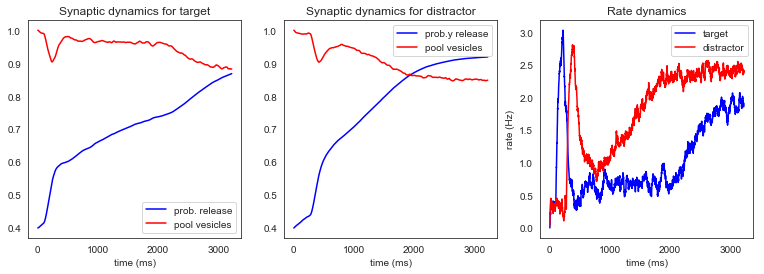

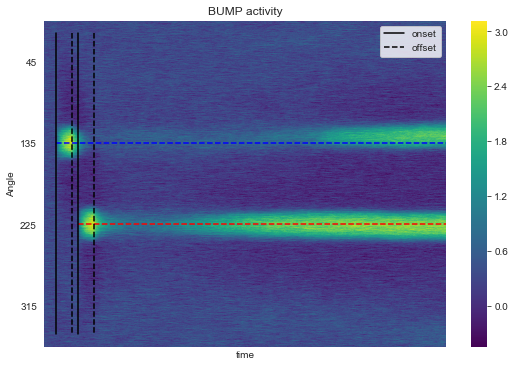

Simulation time: 53.8s


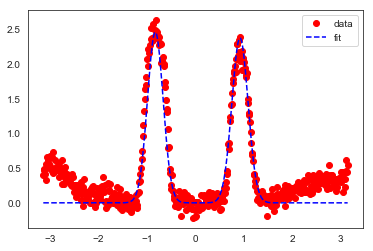

-7.235294117647072 -7.12 -2.73


In [259]:

interference, max_re, bias_target, bias_dist, number_of_bumps, targ_ang, dist_ang, X, y1  = simulation(totalTime=6450, 
                                                                                                      targ_onset = 200, 
                                                                                                      dist_onset=450+100 , 
                                                                                                      presentation_period=250, 
                                                                                                      separation=4, sigE=0.7,
                                                                                                      plot_connectivity=False,
                                                                                                      plot_dyniamic=True,
                                                                                                      plot_heatmap=True, 
                                                                                                      plot_fit=True,
                                                                                                      GEE=0.016)

##

print(interference, bias_target, bias_dist)

In [ ]:
### plot target and distractor on top of fit

***Simulation 1_7***

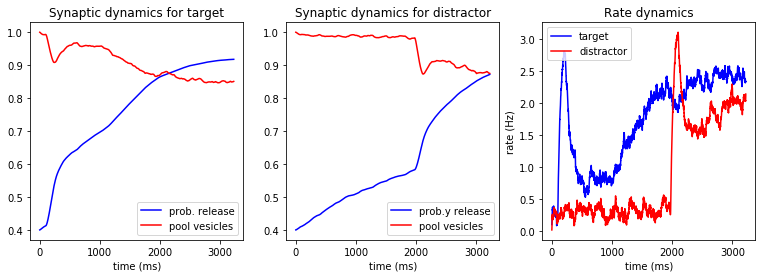

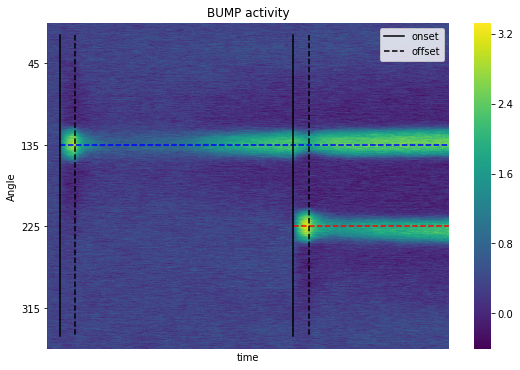

Simulation time: 61.6s


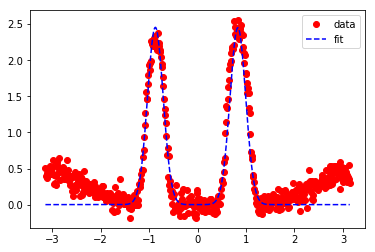

-2.2941176470588402 -2.2 -5.18


In [185]:
interference, max_re, bias_target, bias_dist, number_of_bumps, targ_ang, dist_ang, X, y  = simulation(totalTime=6450, 
                                                                                                      targ_onset = 200, 
                                                                                                      dist_onset=450+3500 , 
                                                                                                      presentation_period=250, 
                                                                                                      separation=4, sigE=0.7,
                                                                                                      plot_connectivity=False,
                                                                                                      plot_dyniamic=True,
                                                                                                      plot_heatmap=True, 
                                                                                                      plot_fit=True, 
                                                                                                      GEE=0.016)

print(interference, bias_target, bias_dist)

In [ ]:
# N=512
# plt.plot(np.linspace(180,0,int(N/2)),y[int(N/2):], label='far')
# plt.plot(np.linspace(180,0,int(N/2)), y1[int(N/2):], label='close')
# plt.legend()


# dec_far = np.linspace(180,0,int(N/2))[np.where(y[int(N/2):]==max(y[int(N/2):]))[0][0]]
# dec_close = np.linspace(180,0,int(N/2))[np.where(y1[int(N/2):]==max(y1[int(N/2):]))[0][0]]
# int_close = dec_close - np.degrees( pi - pi/4)
# int_far = dec_far - np.degrees( pi - pi/4)

In [189]:

def simulation_2_7(totalTime, targ_onset, dist_onset, presentation_period, separation, inhib_curr,
               time_ex_input=10, tauE=60, tauI=10, tauf=7000, taud=80, I0E=1.3, I0I=0.4, U=0.4,
               GEE=0.0165, GEI=0.015, GIE=0.012 , GII=0.007, sigE=0.06, sigI=0.04,
               kappa_E=100, kappa_I=1.5, k_inhib=0.07, kappa_stim=20,
               N=512, plot_connectivity=True, plot_dyniamic=True, plot_heatmap=True, plot_fit=True ):
    
    ###### temporal and spatial settings
    st_sim =time.time()
    dt=2;
    nsteps=int(floor(totalTime/dt));
    origin = pi;
    targ_offset = targ_onset + presentation_period;
    targon = floor(targ_onset/dt);
    targoff = floor(targ_offset/dt);
    
    dist_offset = dist_onset  + presentation_period;
    diston = floor(dist_onset/dt);
    distoff = floor(dist_offset/dt);
    stim_sep = pi/separation; #(13 attract, 9 solo 1, 5 repulsion, 2 nada)
    
    targ_dist_delay = dist_onset - targ_offset
    
    if inhib_curr == True:
        I0E_open = I0E
        I0E_close=I0E_open-0.9
        I0E = I0E_close    
    
    ###### Connectivities
    v_E=np.zeros((N));
    v_I=np.zeros((N));
    WE=np.zeros((N,N));
    WI=np.zeros((N,N));
    theta = [float(range(0,N)[i])/N*2*pi for i in range(0,N)];
    for i in range(0, N):
        v_E_new=[e**(kappa_E*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_E)) for f in range(0, len(theta))]    
        v_I_new=[e**(kappa_I*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_I)) + k_inhib for f in range(0, len(theta))] #0.18
        ###    
        vE_NEW=np.roll(v_E_new,i)
        vI_NEW=np.roll(v_I_new,i) #to roll
        ###    
        WE[:,i]=vE_NEW
        WI[:,i]=vI_NEW
    
    #
    # Plot of the connectivity profile
    if plot_connectivity ==True:
        plt.figure()
        plt.plot(WE[250, :], label='E')
        plt.plot(WI[250, :], label = 'I')
        plt.ylim(0,6)
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.title('Connectivity WE & WI')
        plt.show(block=False)
        plt.figure()
        plt.plot(WE[250, :] - WI[250, :] , label='E-I')
        #plt.plot(WI[250, :], label = 'I')
        #plt.ylim(0,6)
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.title('Effective onnectivity')
        plt.show(block=False)
    
    #topography_pattern  =  WE[250, :] + -1*(WI[250, :]) ##plot the topography of the connectivities
    #plt.plot(topography_pattern, 'k')
    #plt.show(block=False)
    
    ###### Stimuli
    target=np.zeros((N))
    distractor=np.zeros((N))
    for i in range(0, N):
        target[i]=e**(kappa_stim*cos(theta[i] + origin - stim_sep)) / (2*pi*scipy.special.i0(kappa_stim)) 
        distractor[i]=e**(kappa_stim*cos(theta[i] + origin + stim_sep)) / (2*pi*scipy.special.i0(kappa_stim)) 


    target = target+ np.random.normal(0, 0.01, N)
    target=reshape(target, (N,1))
    distractor = distractor+ np.random.normal(0, 0.01, N)
    distractor=reshape(distractor, (N,1)) 
    
    #plt.plot(target) ##plot the target and distractor
    #plt.plot(distractor)
    #plt.show(block=False)
    
    ###### Model   
    rE=np.zeros((N,1));
    rI=np.zeros((N,1)); 
    u = np.ones((N,1))*U
    x = np.ones((N,1))
    RE=np.zeros((N,nsteps));
    RI=np.zeros((N,nsteps));
    p_u=np.ones((N,nsteps));
    p_x=np.ones((N,nsteps));
    
    f = lambda x : x*x*(x>0)*(x<1) + reshape(array([cmath.sqrt(4*x[i]-3) for i in range(0, len(x))]).real, (N,1)) * (x>=1)
    
    ### diferential equations
    for i in range(0, nsteps):
        noiseE = sigE*random.randn(N,1);
        noiseI = sigI*random.randn(N,1);

        #differential equations for connectivity
        IE= GEE*dot(WE, (rE*u*x)) - GIE*dot(WI,rI) + I0E*ones((N,1)); 
        II= GEI*dot(WE,rE) +  (I0I-GII*mean(rI))*ones((N,1));

        if i>targon and i<targoff:
            IE=IE+target;
            II=II+target;

        if i>diston and i<distoff:
            IE=IE+distractor;
            II=II+distractor;
        
        if inhib_curr == True:            
            if i > distoff and i< distoff +200:
                I0E=I0E_open
                
            if i > distoff+200 and i< targon-500 :
                I0E=I0E_close
                
            if i > targon-500 :
                I0E=I0E_open
        
        ###
        #rates of exit and inhib   
        rE = rE + (f(IE) - rE + noiseE)*dt/tauE;
        rI = rI + (f(II) - rI + noiseI)*dt/tauI;
        ### formulas for synaptic plasticity: paper mongillo 2008
        u = u + ((U - u) / tauf + U*(1-u)*rE/1000)*dt;
        x = x + ((1 - x)/taud - u*x*rE/1000)*dt;
        
        rEr=np.reshape(rE, N)
        rIr=np.reshape(rI, N)
        ur=np.reshape(u, N)
        xr=np.reshape(x, N)
        #append
        RE[:,i] = rEr;
        RI[:,i] = rIr;
        p_u[:,i] = ur;
        p_x[:,i] = xr;
    
    
    #### Interference
    interference = Interference_effects( [decode_rE(target)], [decode_rE(rE)], [decode_rE(distractor)])[0]
    p_targ = int((N * np.degrees(origin + stim_sep))/360)
    if plot_dyniamic==True:
        #### plot dynamics
        fig = plt.figure()
        fig.tight_layout()
        fig.set_size_inches(13, 4)
        fig.add_subplot(131)
        p_targ = int((N * np.degrees(origin + stim_sep))/360)
        plt.title('Synaptic dynamics for target')
        plt.plot(p_u[p_targ, :], 'b', label='prob. release')
        plt.plot(p_x[p_targ, :], 'r', label='pool vesicles')
        plt.xlabel('time (ms)')
        plt.legend()
        fig.add_subplot(132)
        p_dist= int((N * np.degrees(origin - stim_sep))/360)
        plt.title('Synaptic dynamics for distractor')
        plt.plot(p_u[p_dist, :], 'b', label='prob.y release')
        plt.plot(p_x[p_dist, :], 'r', label='pool vesicles')
        plt.xlabel('time (ms)')
        plt.legend()
        fig.add_subplot(133)
        plt.title('Rate dynamics')
        plt.plot(RE[p_targ, :], 'b', label='target')
        plt.plot(RE[p_dist, :], 'r', label='distractor')
        plt.xlabel('time (ms)')
        plt.ylabel('rate (Hz)')
        plt.legend()
        plt.show(block=False)
    #
    if plot_heatmap==True:
        #### plot heatmap
        p_dist= int((N * np.degrees(origin - stim_sep))/360)
        RE_sorted=flipud(RE)
        plt.figure(figsize=(9,6))
        sns.heatmap(RE_sorted, cmap='viridis')
        plt.title('BUMP activity')
        plt.ylabel('Angle')
        plt.xlabel('time')
        plt.plot([targon, nsteps], [p_dist, p_dist], '--b',) ## flipped, so it is p_target 
        plt.plot([diston, nsteps], [p_targ, p_targ], '--r',) ## flipped, so it is p_target 
        plt.yticks([])
        plt.xticks([])
        plt.yticks([N/8, 3*N/8, 5*N/8, 7*N/8 ] ,['45','135','225', '315'])
        plt.plot([targ_onset/2, targ_onset/2,], [0+20, N-20], 'k-', label='onset')
        plt.plot([targ_offset/2, targ_offset/2,], [0+20, N-20], 'k--', label='offset')
        plt.plot([dist_onset/2, dist_onset/2,], [0+20, N-20], 'k-')
        plt.plot([dist_offset/2, dist_offset/2,], [0+20, N-20], 'k--')
        plt.legend()
        plt.show(block=False)
    
    
    ## print time consumed
    end_sim =time.time()
    total_time= end_sim - st_sim 
    total_time = round(total_time, 1)
    print('Simulation time: ' + str(total_time) + 's')
    
    #### Fit
    ###### Fit
    def von_misses(x,mu,k):
        return (exp( k * cos(x-mu))) / (2*pi*scipy.special.i0(k)) 

    def bi_von_misses(x,mu1,k1,mu2,k2):
        return von_misses(x,mu1,k1) + von_misses(x,mu2,k2)

    ##
    y=np.reshape(rE, (N)) 
    X=np.reshape(np.linspace(-pi, pi, N), N)

    ### Fit
    df_n_p=pd.DataFrame()
    df_n_p['rE'] = rE.reshape(512)
    peaks_list=[]
    for n_w_s in range(1, 100):
        r = df_n_p['rE'].rolling(window=n_w_s).mean()
        number_of_bumps = len(scipy.signal.find_peaks(r, 2)[0]) 
        peaks_list.append(number_of_bumps)
    #
    if number_of_bumps == 0:
        if peaks_list==[0 for i in range(len(peaks_list))]:
            number_of_bumps = 0
        else:
            peaks_list[:] = (value for value in peaks_list if value != 0)
            number_of_bumps=most_frequent(peaks_list)
    #
    number_of_bumps=most_frequent(peaks_list)
    #print(number_of_bumps)
    number_of_bumps = 2
    ### Fit
    ### Fit
    if number_of_bumps ==2:
        param, covs = curve_fit(bi_von_misses, X, y, p0=[separation, 75, -separation, 75])
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) + (exp( param[3] * cos(X-param[2]))) / (2*pi*scipy.special.i0(param[3])) 
        estimated_angles=[]
        for p in [param[0], param[2]]:
            estim_ang = np.degrees(p)
            if estim_ang<0:
                estim_ang = 360+estim_ang
            estimated_angles.append(estim_ang)
        
        #          
        estimated_angle_1=estimated_angles[0]
        estimated_angle_2=estimated_angles[1]
        #print(estimated_angle_1, estimated_angle_2)
        estimated_angles = [estimated_angle_1, estimated_angle_2]
        #estimated_angles.sort()
        #
        
        
        ### wich one is the target and which the distractor?????
        
        
        min_bias = min(  abs(np.degrees( origin + pi/separation) - estimated_angle_1 ), abs( np.degrees( origin - pi/separation) - estimated_angle_1  ) )
        if min_bias == abs(np.degrees( origin + pi/separation) - estimated_angle_1 ):
            dist_ang = estimated_angle_1
            targ_ang = estimated_angle_2
            #bias_b1 = np.degrees( origin + pi/separation) -  estimated_angle_1 
            #bias_b2 = np.degrees( origin - pi/separation) -  estimated_angle_2 
            ####
            #bias_dist = Interference_effects(  [np.degrees( origin + pi/separation)],  [dist_ang],  [np.degrees( origin - pi/separation)])[0]
            #bias_target = Interference_effects(  [np.degrees( origin - pi/separation)],  [targ_ang],  [np.degrees( origin + pi/separation)])[0]
            #
            bias_dist = Interference_effects(  [decode_rE(target)],  [dist_ang],  [decode_rE(distractor)])[0]
            bias_target = Interference_effects(  [decode_rE(distractor)],  [targ_ang],  [decode_rE(target)])[0]
            

        else:
            targ_ang = estimated_angle_1
            dist_ang = estimated_angle_2
            #bias_b1 = np.degrees( origin - pi/separation) -  estimated_angle_1 
            #bias_b2 = np.degrees( origin + pi/separation) -  estimated_angle_2 
            ####
            #decode_rE(target)
            #bias_target = Interference_effects(  [np.degrees( origin - pi/separation)],  [targ_ang],  [np.degrees( origin + pi/separation)])[0]
            #bias_dist = Interference_effects(  [np.degrees( origin + pi/separation)],  [dist_ang],  [np.degrees( origin - pi/separation)])[0]
            ##
            bias_target = Interference_effects(  [decode_rE(distractor)],  [targ_ang],  [decode_rE(target)])[0]
            bias_dist = Interference_effects(  [decode_rE(target)],  [dist_ang],  [decode_rE(distractor)])[0]
            
            ##
        
        ###
        #print('target',round(targ_ang,2), round(decode_rE(distractor), 2), round(bias_target,2))
        #print('distractor', round(dist_ang,2), round(decode_rE(target),2), round(bias_dist,2))
        final_bias = [bias_target, bias_dist]
        skip_r_sq=False
        success=True
        #print(np.degrees( origin - pi/separation), decode_rE(target))
        #print(np.degrees( origin + pi/separation), decode_rE(distractor))
        #print(targ_ang, dist_ang)


    elif number_of_bumps ==1:
        param, covs = curve_fit(von_misses, X, y)
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) 
        estimated_angle_1=np.degrees(param[0]+pi)
        estimated_angle_2=np.degrees(param[0]+pi)
        estimated_angle=np.degrees(param[0]+pi)  
        
        min_bias = min(  abs(estimated_angle - np.degrees( origin + pi/separation)), 
                       abs(estimated_angle - np.degrees( origin - pi/separation))  )
        if min_bias == abs(estimated_angle - np.degrees( origin + pi/separation)):
            bias_b1 = estimated_angle - np.degrees( origin + pi/separation)
            bias_b2 = estimated_angle - np.degrees( origin - pi/separation)
        else:
            bias_b1 = estimated_angle - np.degrees( origin - pi/separation)
            bias_b2 = estimated_angle - np.degrees( origin + pi/separation)
        ##
        #bias_b1 = estimated_angle - np.degrees( origin - pi/separation)
        #bias_b2 = np.degrees(origin + pi/separation) - estimated_angle  ## bias (positive means attraction)
        final_bias = [bias_b1, bias_b2]  
        skip_r_sq=False
        success=True

    else:
        print('Error simultaion')
        final_bias=[999, 999]
        plot_fit=False
        skip_r_sq=True
        r_squared=0
        success=False ## to eliminate wrong simulations easily at the end

    #error_fit (r_squared)
    if skip_r_sq==False:
        residuals = y - ans
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-numpy.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)

    #plot fit
    if plot_fit==True:
        plt.figure()
        plt.plot(X, y, 'o', color ='red', label ="data") 
        plt.plot(X, ans, '--', color ='blue', label ="fit") 
        plt.legend() 
        plt.show(block=False) 
    
    ### Output
    #return RE,  RI, p_u, p_x
    #return interference, targ_dist_delay 
    max_re = max(rE)[0]
    ### interfernce max
    dec_far = np.linspace(180,0,int(N/2))[np.where(y[int(N/2):]==max(y[int(N/2):]))[0][0]]
    #dec_close = np.linspace(180,0,int(N/2))[np.where(y1[int(N/2):]==max(y1[int(N/2):]))[0][0]]
    #int_close = dec_close - np.degrees( pi - pi/4)
    int_far = dec_far - np.degrees( pi - pi/4)
    
    return int_far, max_re, bias_dist, bias_target,  number_of_bumps, targ_ang, dist_ang, X, y #rE[p_targ][0], I0E

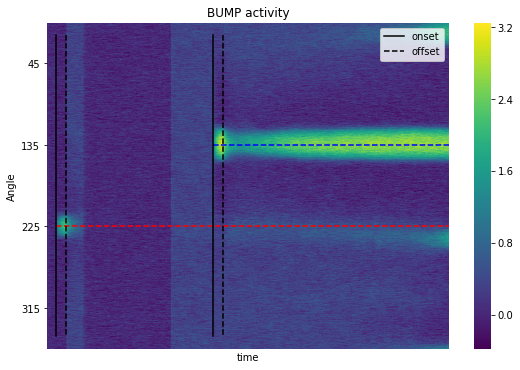

Simulation time: 75.0s


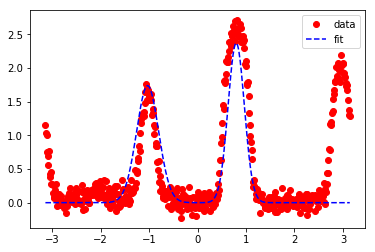

-1.588235294117652 -0.24 -14.44


In [190]:
interference, max_re, bias_target, bias_dist, number_of_bumps, targ_ang, dist_ang, X, y  = simulation_2_7(totalTime=9600,
                                                                                                          targ_onset = 3950,
                                                                                                          dist_onset=200, 
                                                                                                          presentation_period=250,
                                                                                                          separation=4, 
                                                                                                          inhib_curr=True, 
                                                                                                          time_ex_input=0, 
                                                                                                          sigE=0.7, 
                                                                                                          plot_connectivity=False, 
                                                                                                          plot_dyniamic=False, 
                                                                                                          plot_heatmap=True, 
                                                                                                          plot_fit=True )
print(interference, bias_target, bias_dist)

In [192]:

def simulation_o2(totalTime, targ_onset, dist_onset, presentation_period, separation, inhib_curr,
               time_ex_input=10, tauE=60, tauI=10, tauf=7000, taud=80, I0E=1.3, I0I=0.4, U=0.4,
               GEE=0.0165, GEI=0.015, GIE=0.012 , GII=0.007, sigE=0.06, sigI=0.04,
               kappa_E=100, kappa_I=1.5, k_inhib=0.07, kappa_stim=20,
               N=512, plot_connectivity=True, plot_dyniamic=True, plot_heatmap=True, plot_fit=True ):
    
    ###### temporal and spatial settings
    st_sim =time.time()
    dt=2;
    nsteps=int(floor(totalTime/dt));
    origin = pi;
    targ_offset = targ_onset + presentation_period;
    targon = floor(targ_onset/dt);
    targoff = floor(targ_offset/dt);
    
    dist_offset = dist_onset  + presentation_period;
    diston = floor(dist_onset/dt);
    distoff = floor(dist_offset/dt);
    stim_sep = pi/separation; #(13 attract, 9 solo 1, 5 repulsion, 2 nada)
    
    targ_dist_delay = dist_onset - targ_offset
    
    if inhib_curr == True:
        I0E_open = I0E
        I0E=I0E_open-0.9
    
    ###### Connectivities
    v_E=np.zeros((N));
    v_I=np.zeros((N));
    WE=np.zeros((N,N));
    WI=np.zeros((N,N));
    theta = [float(range(0,N)[i])/N*2*pi for i in range(0,N)];
    for i in range(0, N):
        v_E_new=[e**(kappa_E*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_E)) for f in range(0, len(theta))]    
        v_I_new=[e**(kappa_I*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_I)) + k_inhib for f in range(0, len(theta))] #0.18
        ###    
        vE_NEW=np.roll(v_E_new,i)
        vI_NEW=np.roll(v_I_new,i) #to roll
        ###    
        WE[:,i]=vE_NEW
        WI[:,i]=vI_NEW
    
    #
        # Plot of the connectivity profile
    if plot_connectivity ==True:
        plt.figure()
        plt.plot(WE[250, :], label='E')
        plt.plot(WI[250, :], label = 'I')
        plt.ylim(0,6)
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.title('Connectivity WE & WI')
        plt.show(block=False)
        plt.figure()
        plt.plot(WE[250, :] - WI[250, :] , label='E-I')
        #plt.plot(WI[250, :], label = 'I')
        #plt.ylim(0,6)
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.title('Effective onnectivity')
        plt.show(block=False)
    #topography_pattern  =  WE[250, :] + -1*(WI[250, :]) ##plot the topography of the connectivities
    #plt.plot(topography_pattern, 'k')
    #plt.show(block=False)
    
    ###### Stimuli
    target=np.zeros((N))
    distractor=np.zeros((N))
    for i in range(0, N):
        target[i]=e**(kappa_stim*cos(theta[i] + origin - stim_sep)) / (2*pi*scipy.special.i0(kappa_stim)) 
        distractor[i]=e**(kappa_stim*cos(theta[i] + origin + stim_sep)) / (2*pi*scipy.special.i0(kappa_stim)) 


    target = target+ np.random.normal(0, 0.01, N)
    target=reshape(target, (N,1))
    distractor = distractor+ np.random.normal(0, 0.01, N)
    distractor=reshape(distractor, (N,1)) 
    
    #plt.plot(target) ##plot the target and distractor
    #plt.plot(distractor)
    #plt.show(block=False)
    
    ###### Model   
    rE=np.zeros((N,1));
    rI=np.zeros((N,1)); 
    u = np.ones((N,1))*U
    x = np.ones((N,1))
    RE=np.zeros((N,nsteps));
    RI=np.zeros((N,nsteps));
    p_u=np.ones((N,nsteps));
    p_x=np.ones((N,nsteps));
    
    f = lambda x : x*x*(x>0)*(x<1) + reshape(array([cmath.sqrt(4*x[i]-3) for i in range(0, len(x))]).real, (N,1)) * (x>=1)
    
    ### diferential equations
    for i in range(0, nsteps):
        noiseE = sigE*random.randn(N,1);
        noiseI = sigI*random.randn(N,1);

        #differential equations for connectivity
        IE= GEE*dot(WE, (rE*u*x)) - GIE*dot(WI,rI) + I0E*ones((N,1)); 
        II= GEI*dot(WE,rE) +  (I0I-GII*mean(rI))*ones((N,1));

        if i>targon and i<targoff:
            IE=IE+target;
            II=II+target;

        if i>diston and i<distoff:
            IE=IE+distractor;
            II=II+distractor;
        
        if inhib_curr == True:
            if i > distoff+time_ex_input:
                I0E=I0E_open
        
        ###
        #rates of exit and inhib   
        rE = rE + (f(IE) - rE + noiseE)*dt/tauE;
        rI = rI + (f(II) - rI + noiseI)*dt/tauI;
        ### formulas for synaptic plasticity: paper mongillo 2008
        u = u + ((U - u) / tauf + U*(1-u)*rE/1000)*dt;
        x = x + ((1 - x)/taud - u*x*rE/1000)*dt;
        
        rEr=np.reshape(rE, N)
        rIr=np.reshape(rI, N)
        ur=np.reshape(u, N)
        xr=np.reshape(x, N)
        #append
        RE[:,i] = rEr;
        RI[:,i] = rIr;
        p_u[:,i] = ur;
        p_x[:,i] = xr;
    
    
    #### Interference
    interference = Interference_effects( [decode_rE(target)], [decode_rE(rE)], [decode_rE(distractor)])[0]
    
    if plot_dyniamic==True:
        #### plot dynamics
        fig = plt.figure()
        fig.tight_layout()
        fig.set_size_inches(13, 4)
        fig.add_subplot(131)
        p_targ = int((N * np.degrees(origin + stim_sep))/360)
        plt.title('Synaptic dynamics for target')
        plt.plot(p_u[p_targ, :], 'b', label='prob. release')
        plt.plot(p_x[p_targ, :], 'r', label='pool vesicles')
        plt.xlabel('time (ms)')
        plt.legend()
        fig.add_subplot(132)
        p_dist= int((N * np.degrees(origin - stim_sep))/360)
        plt.title('Synaptic dynamics for distractor')
        plt.plot(p_u[p_dist, :], 'b', label='prob.y release')
        plt.plot(p_x[p_dist, :], 'r', label='pool vesicles')
        plt.xlabel('time (ms)')
        plt.legend()
        fig.add_subplot(133)
        plt.title('Rate dynamics')
        plt.plot(RE[p_targ, :], 'b', label='target')
        plt.plot(RE[p_dist, :], 'r', label='distractor')
        plt.xlabel('time (ms)')
        plt.ylabel('rate (Hz)')
        plt.legend()
        plt.show(block=False)

    if plot_heatmap==True:
        #### plot heatmap
        p_dist= int((N * np.degrees(origin - stim_sep))/360)
        RE_sorted=flipud(RE)
        plt.figure(figsize=(9,6))
        sns.heatmap(RE_sorted, cmap='viridis')
        plt.title('BUMP activity')
        plt.ylabel('Angle')
        plt.xlabel('time')
        plt.plot([targon, nsteps], [p_dist, p_dist], '--b',) ## flipped, so it is p_target 
        plt.plot([diston, nsteps], [p_targ, p_targ], '--r',) ## flipped, so it is p_target 
        plt.yticks([])
        plt.xticks([])
        plt.yticks([N/8, 3*N/8, 5*N/8, 7*N/8 ] ,['45','135','225', '315'])
        plt.plot([targ_onset/2, targ_onset/2,], [0+20, N-20], 'k-', label='onset')
        plt.plot([targ_offset/2, targ_offset/2,], [0+20, N-20], 'k--', label='offset')
        plt.plot([dist_onset/2, dist_onset/2,], [0+20, N-20], 'k-')
        plt.plot([dist_offset/2, dist_offset/2,], [0+20, N-20], 'k--')
        plt.legend()
        plt.show(block=False)
    
    
    ## print time consumed
    end_sim =time.time()
    total_time= end_sim - st_sim 
    total_time = round(total_time, 1)
    print('Simulation time: ' + str(total_time) + 's')
    
    #### Fit
    ###### Fit
    def von_misses(x,mu,k):
        return (exp( k * cos(x-mu))) / (2*pi*scipy.special.i0(k)) 

    def bi_von_misses(x,mu1,k1,mu2,k2):
        return von_misses(x,mu1,k1) + von_misses(x,mu2,k2)

    ##
    y=np.reshape(rE, (N)) 
    X=np.reshape(np.linspace(-pi, pi, N), N)

    ### Fit
    df_n_p=pd.DataFrame()
    df_n_p['rE'] = rE.reshape(512)
    peaks_list=[]
    for n_w_s in range(1, 100):
        r = df_n_p['rE'].rolling(window=n_w_s).mean()
        number_of_bumps = len(scipy.signal.find_peaks(r, 2)[0]) 
        peaks_list.append(number_of_bumps)
    #
    if number_of_bumps == 0:
        if peaks_list==[0 for i in range(len(peaks_list))]:
            number_of_bumps = 0
        else:
            peaks_list[:] = (value for value in peaks_list if value != 0)
            number_of_bumps=most_frequent(peaks_list)
    #
    number_of_bumps=most_frequent(peaks_list)
    #print(number_of_bumps)
    number_of_bumps = 2


    ### Fit    
    if number_of_bumps ==2:
        param, covs = curve_fit(bi_von_misses, X, y, p0=[separation, 75, -separation, 75])
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) + (exp( param[3] * cos(X-param[2]))) / (2*pi*scipy.special.i0(param[3])) 
        estimated_angles=[]
        for p in [param[0], param[2]]:
            estim_ang = np.degrees(p)
            if estim_ang<0:
                estim_ang = 360+estim_ang
            estimated_angles.append(estim_ang)
        
        #          
        estimated_angle_1=estimated_angles[0]
        estimated_angle_2=estimated_angles[1]
        #print(estimated_angle_1, estimated_angle_2)
        estimated_angles = [estimated_angle_1, estimated_angle_2]
        #estimated_angles.sort()
        #
        
        
        ### wich one is the target and which the distractor?????
        
        
        min_bias = min(  abs(np.degrees( origin + pi/separation) - estimated_angle_1 ), abs( np.degrees( origin - pi/separation) - estimated_angle_1  ) )
        if min_bias == abs(np.degrees( origin + pi/separation) - estimated_angle_1 ):
            dist_ang = estimated_angle_1
            targ_ang = estimated_angle_2
            #bias_b1 = np.degrees( origin + pi/separation) -  estimated_angle_1 
            #bias_b2 = np.degrees( origin - pi/separation) -  estimated_angle_2 
            ####
            #bias_dist = Interference_effects(  [np.degrees( origin + pi/separation)],  [dist_ang],  [np.degrees( origin - pi/separation)])[0]
            #bias_target = Interference_effects(  [np.degrees( origin - pi/separation)],  [targ_ang],  [np.degrees( origin + pi/separation)])[0]
            #
            bias_dist = Interference_effects(  [decode_rE(target)],  [dist_ang],  [decode_rE(distractor)])[0]
            bias_target = Interference_effects(  [decode_rE(distractor)],  [targ_ang],  [decode_rE(target)])[0]
            

        else:
            targ_ang = estimated_angle_1
            dist_ang = estimated_angle_2
            #bias_b1 = np.degrees( origin - pi/separation) -  estimated_angle_1 
            #bias_b2 = np.degrees( origin + pi/separation) -  estimated_angle_2 
            ####
            #decode_rE(target)
            #bias_target = Interference_effects(  [np.degrees( origin - pi/separation)],  [targ_ang],  [np.degrees( origin + pi/separation)])[0]
            #bias_dist = Interference_effects(  [np.degrees( origin + pi/separation)],  [dist_ang],  [np.degrees( origin - pi/separation)])[0]
            ##
            bias_target = Interference_effects(  [decode_rE(distractor)],  [targ_ang],  [decode_rE(target)])[0]
            bias_dist = Interference_effects(  [decode_rE(target)],  [dist_ang],  [decode_rE(distractor)])[0]
            
            ##
        
        ###
        #print('target',round(targ_ang,2), round(decode_rE(distractor), 2), round(bias_target,2))
        #print('distractor', round(dist_ang,2), round(decode_rE(target),2), round(bias_dist,2))
        final_bias = [bias_target, bias_dist]
        skip_r_sq=False
        success=True
        #print(np.degrees( origin - pi/separation), decode_rE(target))
        #print(np.degrees( origin + pi/separation), decode_rE(distractor))
        #print(targ_ang, dist_ang)
    
    ###
    elif number_of_bumps ==1:
        param, covs = curve_fit(von_misses, X, y)
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) 
        estimated_angle=np.degrees(param[0]+pi)  
        
        min_bias = min(  abs(estimated_angle - np.degrees( origin + pi/separation)), 
                       abs(estimated_angle - np.degrees( origin - pi/separation))  )
        if min_bias == abs(estimated_angle - np.degrees( origin + pi/separation)):
            bias_b1 = estimated_angle - np.degrees( origin + pi/separation)
            bias_b2 = estimated_angle - np.degrees( origin - pi/separation)
        else:
            bias_b1 = estimated_angle - np.degrees( origin - pi/separation)
            bias_b2 = estimated_angle - np.degrees( origin + pi/separation)
        ##
        #bias_b1 = estimated_angle - np.degrees( origin - pi/separation)
        #bias_b2 = np.degrees(origin + pi/separation) - estimated_angle  ## bias (positive means attraction)
        final_bias = [bias_b1, bias_b2]  
        skip_r_sq=False
        success=True

    else:
        print('Error simultaion')
        final_bias=[999, 999]
        plot_fit=False
        skip_r_sq=True
        r_squared=0
        success=False ## to eliminate wrong simulations easily at the end

    #error_fit (r_squared)
    if skip_r_sq==False:
        residuals = y - ans
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-numpy.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)

    #plot fit
    if plot_fit==True:
        plt.figure()
        plt.plot(X, y, 'o', color ='red', label ="data") 
        plt.plot(X, ans, '--', color ='blue', label ="fit") 
        plt.legend() 
        plt.show(block=False) 
    
    ### Output
    #return RE,  RI, p_u, p_x
    #return interference, targ_dist_delay 
    max_re = max(rE)[0]
    ### interfernce max
    dec_far = np.linspace(180,0,int(N/2))[np.where(y[int(N/2):]==max(y[int(N/2):]))[0][0]]
    #dec_close = np.linspace(180,0,int(N/2))[np.where(y1[int(N/2):]==max(y1[int(N/2):]))[0][0]]
    #int_close = dec_close - np.degrees( pi - pi/4)
    int_far = dec_far - np.degrees( pi - pi/4)
    
    return int_far, max_re, bias_dist, bias_target,  number_of_bumps, targ_ang, dist_ang, X, y #rE[p_targ][0], I0E

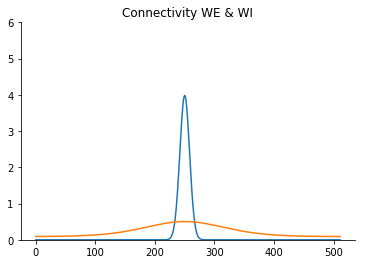

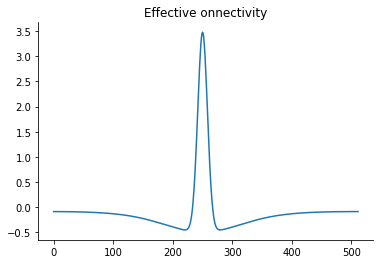

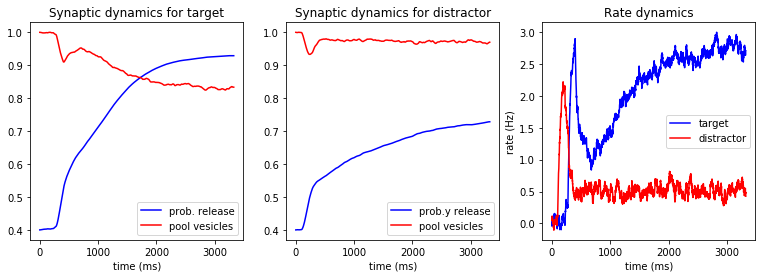

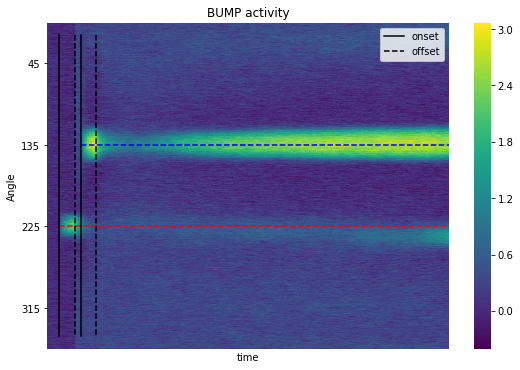

Simulation time: 55.7s


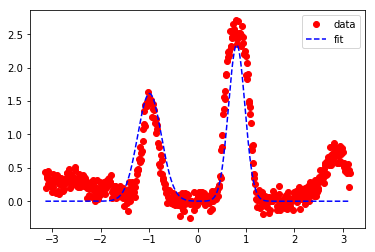

-0.17647058823530415 -0.79 -12.01


In [194]:
interference, max_re, bias_target, bias_dist, number_of_bumps, targ_ang, dist_ang, X, y  =  simulation_o2(totalTime=6650,
                                                                                                          targ_onset = 550, 
                                                                                                          dist_onset=200, 
                                                                                                          presentation_period=250, 
                                                                                                          separation=4, 
                                                                                                          inhib_curr=True, 
                                                                                                          time_ex_input=0, 
                                                                                                          sigE=0.7 )


print(interference, bias_target, bias_dist)

In [204]:
biases_o1_d02 = []

for sim in range(300):
    interference, max_re, bias_target, bias_dist, number_of_bumps, targ_ang, dist_ang, X, y1  = simulation(totalTime=6450, 
                                                                                                          targ_onset = 200, 
                                                                                                          dist_onset=450+100 , 
                                                                                                          presentation_period=250, 
                                                                                                          separation=4, sigE=0.7,
                                                                                                          plot_connectivity=False,
                                                                                                          plot_dyniamic=False,
                                                                                                          plot_heatmap=False, 
                                                                                                          plot_fit=False,
                                                                                                          GEE=0.016)

    ##

    biases_o1_d02.append([interference, bias_target, bias_dist])

Simulation time: 27.2s
Simulation time: 28.7s
Simulation time: 31.9s
Simulation time: 29.1s
Simulation time: 27.1s
Simulation time: 27.9s
Simulation time: 29.1s
Simulation time: 31.6s
Simulation time: 29.4s
Simulation time: 26.3s
Simulation time: 27.9s
Simulation time: 29.9s
Simulation time: 31.7s
Simulation time: 28.0s
Simulation time: 25.9s
Simulation time: 26.5s
Simulation time: 29.2s
Simulation time: 31.2s
Simulation time: 30.1s
Simulation time: 27.1s
Simulation time: 26.7s
Simulation time: 27.5s
Simulation time: 31.5s
Simulation time: 29.4s
Simulation time: 27.0s
Simulation time: 25.4s
Simulation time: 28.3s
Simulation time: 29.9s
Simulation time: 30.0s
Simulation time: 27.0s
Simulation time: 25.5s
Simulation time: 27.8s
Simulation time: 29.3s
Simulation time: 28.8s
Simulation time: 26.1s
Simulation time: 24.6s
Simulation time: 24.9s
Simulation time: 25.4s
Simulation time: 29.1s
Simulation time: 26.8s
Simulation time: 25.6s
Simulation time: 24.5s
Simulation time: 26.9s
Simulation 

In [205]:
biases_o1_d02

[[-4.411764705882348, -5.74, -3.94],
 [-5.117647058823536, -5.29, -2.77],
 [-8.64705882352942, -6.45, -3.09],
 [-5.823529411764696, -7.25, -2.06],
 [-6.529411764705884, -7.64, -2.03],
 [-8.64705882352942, -7.52, -2.44],
 [-3.0, -5.25, -5.13],
 [-5.823529411764696, -5.33, -2.78],
 [-4.411764705882348, -6.14, -3.01],
 [-4.411764705882348, -7.27, -3.01],
 [-3.705882352941188, -4.37, -4.33],
 [-4.411764705882348, -5.12, -3.91],
 [-3.705882352941188, -5.71, -4.51],
 [-8.64705882352942, -6.45, -2.97],
 [-6.529411764705884, -6.66, -2.88],
 [-10.764705882352942, -8.36, -2.2],
 [-5.117647058823536, -5.15, -3.37],
 [-4.411764705882348, -5.76, -3.09],
 [-7.235294117647072, -5.76, -3.03],
 [-3.0, -5.98, -3.08],
 [-7.235294117647072, -6.99, -1.73],
 [-4.411764705882348, -5.94, -3.61],
 [-3.705882352941188, -6.41, -2.71],
 [-10.058823529411768, -8.35, -3.29],
 [-9.352941176470594, -5.44, -3.42],
 [-7.235294117647072, -6.02, -3.69],
 [-6.529411764705884, -6.99, -2.92],
 [-7.235294117647072, -6.87, -2

In [206]:
biases_o1_d7=[]

for sim in range(300):
    interference, max_re, bias_target, bias_dist, number_of_bumps, targ_ang, dist_ang, X, y  = simulation(totalTime=6450, 
                                                                                                          targ_onset = 200, 
                                                                                                          dist_onset=450+3500 , 
                                                                                                          presentation_period=250, 
                                                                                                          separation=4, sigE=0.7,
                                                                                                          plot_connectivity=False,
                                                                                                          plot_dyniamic=False,
                                                                                                          plot_heatmap=False, 
                                                                                                          plot_fit=False, 
                                                                                                          GEE=0.016)

    biases_o1_d7.append([interference, bias_target, bias_dist])

Simulation time: 25.4s
Simulation time: 26.8s
Simulation time: 26.2s
Simulation time: 25.1s
Simulation time: 25.4s
Simulation time: 25.1s
Simulation time: 25.7s
Simulation time: 26.4s
Simulation time: 25.0s
Simulation time: 25.2s
Simulation time: 25.3s
Simulation time: 25.4s
Simulation time: 25.2s
Simulation time: 27.0s
Simulation time: 31.1s
Simulation time: 34.6s
Simulation time: 37.8s
Simulation time: 27.2s
Simulation time: 26.7s
Simulation time: 25.3s
Simulation time: 25.5s
Simulation time: 25.3s
Simulation time: 25.8s
Simulation time: 25.5s
Simulation time: 26.0s
Simulation time: 25.4s
Simulation time: 24.7s
Simulation time: 24.8s
Simulation time: 25.1s
Simulation time: 24.9s
Simulation time: 26.4s
Simulation time: 24.7s
Simulation time: 25.3s
Simulation time: 25.1s
Simulation time: 25.4s
Simulation time: 26.0s
Simulation time: 26.5s
Simulation time: 24.9s
Simulation time: 25.1s
Simulation time: 25.3s
Simulation time: 25.5s
Simulation time: 25.2s
Simulation time: 25.9s
Simulation 

In [207]:
biases_o1_d7

[[-1.588235294117652, -2.41, -6.4],
 [-4.411764705882348, -3.54, -6.15],
 [-5.117647058823536, -3.23, -7.53],
 [-3.0, -2.1, -6.51],
 [-0.17647058823530415, -2.52, -7.05],
 [-0.17647058823530415, -2.01, -6.59],
 [-3.0, -2.74, -5.5],
 [1.2352941176470722, -1.66, -7.39],
 [-3.0, -2.41, -6.76],
 [-1.588235294117652, -2.6, -7.01],
 [-2.2941176470588402, -1.95, -6.46],
 [-3.0, -2.4, -6.88],
 [-0.17647058823530415, -2.27, -6.29],
 [-5.117647058823536, -2.4, -6.93],
 [-3.0, -2.72, -5.81],
 [-5.117647058823536, -2.62, -7.18],
 [-3.705882352941188, -2.48, -7.3],
 [-3.705882352941188, -2.1, -6.32],
 [-3.0, -2.12, -7.28],
 [-0.17647058823530415, -2.21, -6.81],
 [-0.17647058823530415, -1.92, -5.82],
 [-1.588235294117652, -2.47, -6.33],
 [1.2352941176470722, -2.42, -5.66],
 [-3.0, -2.27, -6.84],
 [-3.0, -2.22, -6.72],
 [-2.2941176470588402, -1.65, -7.01],
 [0.529411764705884, -1.65, -8.5],
 [-0.17647058823530415, -3.03, -6.77],
 [-0.8823529411764639, -2.52, -7.14],
 [-3.0, -2.49, -5.92],
 [-0.882352

In [208]:

biases_o2_d02=[]


for sim in range(300):
    interference, max_re, bias_target, bias_dist, number_of_bumps, targ_ang, dist_ang, X, y  =  simulation_o2(totalTime=6650,
                                                                                                              targ_onset = 550, 
                                                                                                              dist_onset=200, 
                                                                                                              presentation_period=250, 
                                                                                                              separation=4, 
                                                                                                              inhib_curr=True, 
                                                                                                              time_ex_input=0, 
                                                                                                              sigE=0.7, 
                                                                                                              plot_connectivity=False,
                                                                                                              plot_dyniamic=False,
                                                                                                              plot_heatmap=False, 
                                                                                                              plot_fit=False )


    biases_o2_d02.append([interference, bias_target, bias_dist])

Simulation time: 26.0s
Simulation time: 26.1s
Simulation time: 26.0s
Simulation time: 26.2s
Simulation time: 27.0s
Simulation time: 25.7s
Simulation time: 26.6s
Simulation time: 26.1s
Simulation time: 26.0s
Simulation time: 26.0s
Simulation time: 27.3s
Simulation time: 25.9s
Simulation time: 26.1s
Simulation time: 25.9s
Simulation time: 26.1s
Simulation time: 26.0s
Simulation time: 26.0s
Simulation time: 27.6s
Simulation time: 26.0s
Simulation time: 26.0s
Simulation time: 25.9s
Simulation time: 26.6s
Simulation time: 27.0s
Simulation time: 25.7s
Simulation time: 25.9s
Simulation time: 26.1s
Simulation time: 26.0s
Simulation time: 26.7s
Simulation time: 25.9s
Simulation time: 26.8s
Simulation time: 25.7s
Simulation time: 26.4s
Simulation time: 25.9s
Simulation time: 26.6s
Simulation time: 26.8s
Simulation time: 26.2s
Simulation time: 26.0s
Simulation time: 25.8s
Simulation time: 26.1s
Simulation time: 25.8s
Simulation time: 27.0s
Simulation time: 25.7s
Simulation time: 26.3s
Simulation 

In [209]:
biases_o2_d02

[[0.529411764705884, -0.7, -12.07],
 [2.6470588235293917, -0.96, -80.47],
 [0.529411764705884, -0.39, -78.91],
 [1.941176470588232, -0.16, -80.86],
 [4.764705882352928, 0.04, -79.77],
 [-0.8823529411764639, -1.28, -11.35],
 [-2.2941176470588402, -1.03, -9.62],
 [-4.411764705882348, -2.2, -8.11],
 [-0.8823529411764639, -0.77, -79.69],
 [-0.8823529411764639, 0.11, 92.64],
 [1.941176470588232, -1.22, -85.03],
 [2.6470588235293917, -1.33, -10.7],
 [1.2352941176470722, -1.0, -10.71],
 [1.941176470588232, -0.96, -11.25],
 [0.529411764705884, -1.3, -88.23],
 [-0.17647058823530415, -0.73, -80.37],
 [-4.411764705882348, -1.63, -14.15],
 [-3.0, -0.49, -84.46],
 [-1.588235294117652, -1.63, -9.11],
 [-3.705882352941188, -1.28, -9.61],
 [-2.2941176470588402, -1.87, -7.68],
 [-4.411764705882348, -0.48, -84.56],
 [-1.588235294117652, -0.77, -59.88],
 [-0.8823529411764639, -0.93, 90.78],
 [-5.117647058823536, -0.48, -89.27],
 [-0.17647058823530415, -2.58, -10.65],
 [2.6470588235293917, -0.55, -91.79],

In [210]:

biases_o2_d7=[]

for sim in range(300):
    interference, max_re, bias_target, bias_dist, number_of_bumps, targ_ang, dist_ang, X, y  = simulation_2_7(totalTime=9600,
                                                                                                              targ_onset = 3950,
                                                                                                              dist_onset=200, 
                                                                                                              presentation_period=250,
                                                                                                              separation=4, 
                                                                                                              inhib_curr=True, 
                                                                                                              time_ex_input=0, 
                                                                                                              sigE=0.7, 
                                                                                                              plot_connectivity=False, 
                                                                                                              plot_dyniamic=False, 
                                                                                                              plot_heatmap=False, 
                                                                                                              plot_fit=False )
    biases_o2_d7.append([interference, bias_target, bias_dist])

Simulation time: 55.2s
Simulation time: 48.2s
Simulation time: 47.7s
Simulation time: 52.8s
Simulation time: 47.2s
Simulation time: 47.4s
Simulation time: 55.9s
Simulation time: 46.4s
Simulation time: 50.7s
Simulation time: 52.0s
Simulation time: 46.0s
Simulation time: 47.8s
Simulation time: 52.6s
Simulation time: 47.4s
Simulation time: 53.4s
Simulation time: 52.1s
Simulation time: 45.5s
Simulation time: 49.6s
Simulation time: 51.2s
Simulation time: 48.1s
Simulation time: 51.6s
Simulation time: 53.0s
Simulation time: 45.8s
Simulation time: 48.1s
Simulation time: 53.8s
Simulation time: 49.1s
Simulation time: 50.2s
Simulation time: 51.9s
Simulation time: 46.5s
Simulation time: 50.5s
Simulation time: 50.5s
Simulation time: 46.9s
Simulation time: 51.8s
Simulation time: 51.7s
Simulation time: 45.9s
Simulation time: 49.7s
Simulation time: 50.7s
Simulation time: 45.8s
Simulation time: 56.3s
Simulation time: 47.0s
Simulation time: 48.3s
Simulation time: 51.9s
Simulation time: 45.4s
Simulation 

In [211]:
biases_o2_d7

[[-2.2941176470588402, -0.02, 64.36],
 [-5.117647058823536, -1.05, -15.11],
 [1.2352941176470722, 1.04, 68.45],
 [-1.588235294117652, -0.88, 82.07],
 [2.6470588235293917, 0.27, 31.49],
 [-0.8823529411764639, -0.85, 79.67],
 [-7.235294117647072, 0.01, -75.64],
 [-5.117647058823536, -0.41, 84.58],
 [1.2352941176470722, -0.06, 32.89],
 [-3.0, -0.09, 79.32],
 [-3.705882352941188, -0.73, -13.12],
 [1.2352941176470722, 0.19, 82.28],
 [2.6470588235293917, -0.02, 52.95],
 [1.2352941176470722, -0.9, 102.23],
 [2.6470588235293917, -1.14, -96.09],
 [0.529411764705884, -0.59, -70.42],
 [-7.235294117647072, -1.66, 59.23],
 [0.529411764705884, -1.1, 53.44],
 [0.529411764705884, 0.45, 36.54],
 [1.941176470588232, -0.4, 36.62],
 [0.529411764705884, -1.05, 80.46],
 [-2.2941176470588402, -0.24, 58.78],
 [1.941176470588232, 0.52, 80.19],
 [0.529411764705884, -0.04, -59.72],
 [-0.8823529411764639, -1.11, 57.44],
 [3.35294117647058, -0.33, 31.39],
 [-2.2941176470588402, -1.78, 35.16],
 [-3.705882352941188,

In [218]:
df_o1_d02 = pd.DataFrame(biases_o1_d02)
df_o1_d02['condition']='1_02'
df_o1_d02['order']=1
df_o1_d02['delay']=0.2
df_o1_d02.columns=['interference', 'bias_target', 'bias_dist', 'condition', 'order', 'delay']


df_o1_d7 = pd.DataFrame(biases_o1_d7)
df_o1_d7['condition']='1_7'
df_o1_d7['order']=1
df_o1_d7['delay']=7
df_o1_d7.columns=['interference', 'bias_target', 'bias_dist', 'condition', 'order', 'delay']

df_o2_d02 = pd.DataFrame(biases_o2_d02)
df_o2_d02['condition']='2_02'
df_o2_d02['order']=2
df_o2_d02['delay']=0.2
df_o2_d02.columns=['interference', 'bias_target', 'bias_dist', 'condition', 'order', 'delay']


df_o2_d7 = pd.DataFrame(biases_o2_d7)
df_o2_d7['condition']='2_7'
df_o2_d7['order']=2
df_o2_d7['delay']=7
df_o2_d7.columns=['interference', 'bias_target', 'bias_dist', 'condition', 'order', 'delay']

df_all = pd.concat([df_o1_d02, df_o1_d7, df_o2_d02, df_o2_d7])
##df_all.to_excel('simul_far_4.xlsx')

,interference,bias_target,bias_dist,condition,order,delay
0,-4.411765,-5.74,-3.94,1_02,1,0.2
1,-5.117647,-5.29,-2.77,1_02,1,0.2
2,-8.647059,-6.45,-3.09,1_02,1,0.2
3,-5.823529,-7.25,-2.06,1_02,1,0.2
4,-6.529412,-7.64,-2.03,1_02,1,0.2
5,-8.647059,-7.52,-2.44,1_02,1,0.2
6,-3.000000,-5.25,-5.13,1_02,1,0.2
7,-5.823529,-5.33,-2.78,1_02,1,0.2
8,-4.411765,-6.14,-3.01,1_02,1,0.2
9,-4.411765,-7.27,-3.01,1_02,1,0.2


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


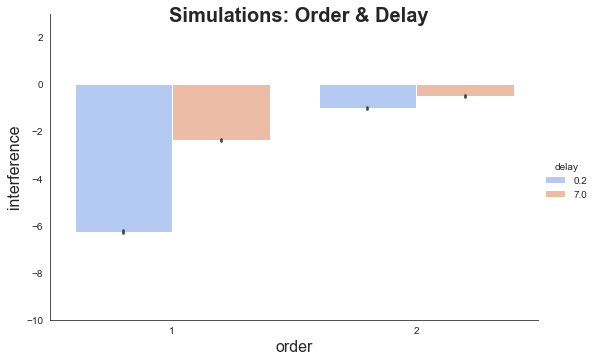

                            OLS Regression Results                            
Dep. Variable:            bias_target   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     4256.
Date:                Tue, 08 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:35:38   Log-Likelihood:                -1262.3
No. Observations:                1200   AIC:                             2533.
Df Residuals:                    1196   BIC:                             2553.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -11.7455      0.092   -127.309      

In [242]:

g = sns.factorplot(x="order", y="bias_target", hue='delay', ci=69, data=df_all,
                   kind='bar', palette='coolwarm', aspect=1.5)


sns.set_style('white')
plt.xlabel('order', fontsize=16)
plt.ylabel('interference', fontsize=16)
plt.ylim(-10,3)
#plt.xticks([0, 1], ['1', '2'], fontsize=14)

g.fig.suptitle('Simulations: Order & Delay', fontsize=20, x=0.5, weight='demibold')


plt.show(block=False)


import statsmodels.formula.api as smf
result = smf.ols(formula="bias_target ~ delay*order ", data=df_all).fit()
print(result.summary())

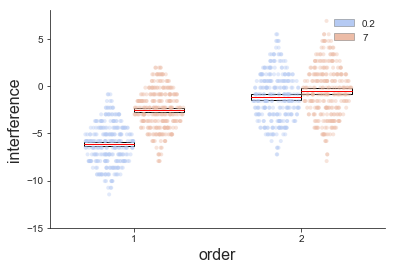

In [234]:
from linares_plot import *

linares_plot(x="order", y="interference", hue='delay', df=df_all, order=[1,2],
             point_size=4, hue_order=[0.2,7], palette='coolwarm')


sns.set_style('white')
plt.xlabel('order', fontsize=16)
plt.ylabel('interference', fontsize=16)
plt.ylim(-15,8);
#plt.xticks([0, 1], ['1', '2'], fontsize=14)